In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2024-08-12 14:10:48.967758: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 14:10:50.329292: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib
2024-08-12 14:10:50.329311: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-08-12 14:10:51.833245: W tensorflow/compiler/xla/stream_executor/platform/defau

In [2]:
print(tf.__version__)

2.11.0


In [4]:
path = "/home/guts/Documents/accel_data/acceleration_data.csv"
df = pd.read_csv(path)
df

,Timestamp,Acceleration
0,2024-08-09 14:23:41,10.110164
1,2024-08-09 14:23:42,9.555678
2,2024-08-09 14:23:44,9.325334
3,2024-08-09 14:23:48,9.532025
4,2024-08-09 14:23:49,9.468498
...,...,...
18662,2024-08-10 01:05:10,9.490646
18663,2024-08-10 01:05:13,10.447052
18664,2024-08-10 01:05:15,9.073947
18665,2024-08-10 01:05:16,10.054511


In [5]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Timestamp'] = df['Timestamp'].dt.floor('s')
df

,Timestamp,Acceleration
0,2024-08-09 14:23:41,10.110164
1,2024-08-09 14:23:42,9.555678
2,2024-08-09 14:23:44,9.325334
3,2024-08-09 14:23:48,9.532025
4,2024-08-09 14:23:49,9.468498
...,...,...
18662,2024-08-10 01:05:10,9.490646
18663,2024-08-10 01:05:13,10.447052
18664,2024-08-10 01:05:15,9.073947
18665,2024-08-10 01:05:16,10.054511


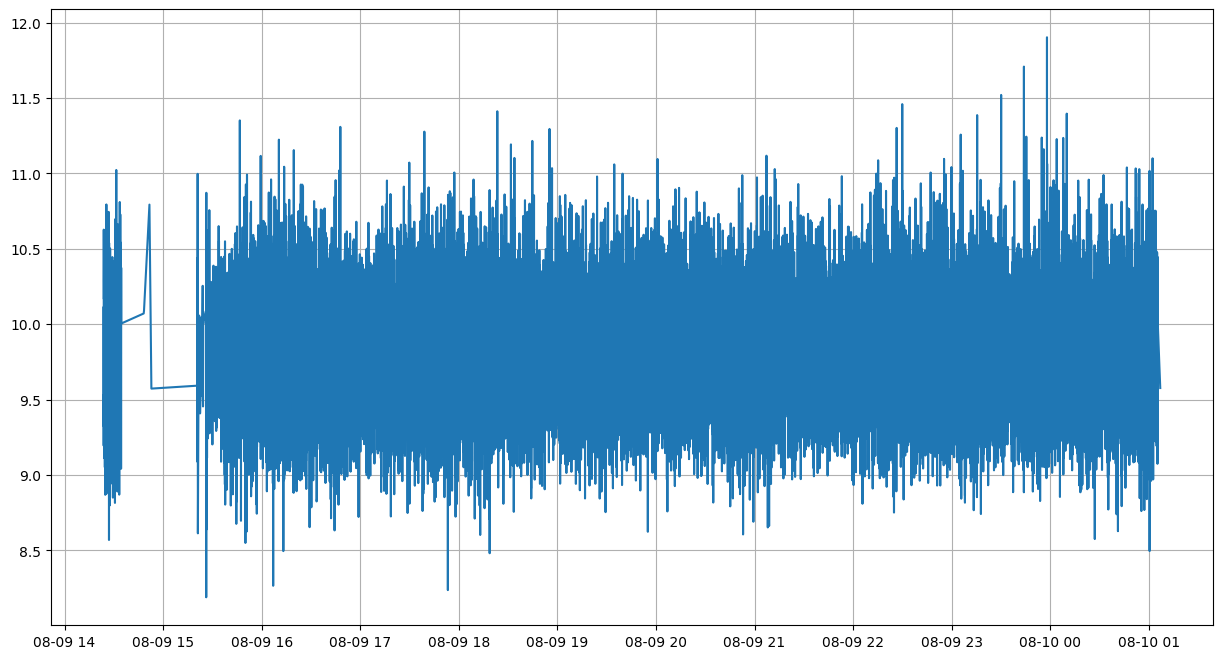

In [6]:
plt.figure(figsize=(15, 8))
plt.plot(df['Timestamp'], df['Acceleration'])
plt.grid()

plt.show()

In [7]:
def df_to_x_y(df, window_size):
    df_as_np = df.to_numpy()
    x = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        x.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(x), np.array(y)

In [8]:
WINDOW_SIZE = 5
x, y =df_to_x_y(df['Acceleration'], WINDOW_SIZE)
x.shape, y.shape

((18662, 5, 1), (18662,))

In [9]:
X_train, y_train = x[:12000], y[:12000]
X_val, y_val = x[12000:17000], y[12000:17000]
X_test, y_test = x[17000:], y[17000:]

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer


model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, activation='relu'))
model1.add(Dense(1, 'linear'))
model1.summary()

2024-08-12 14:11:18.393045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 14:11:18.402922: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib
2024-08-12 14:11:18.403059: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x8

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [11]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError


# Define the ModelCheckpoint callback
cp = ModelCheckpoint(filepath='models/best_model.h5', save_best_only=True)

# Compile the model
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Now you can train the model using this checkpoint

model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [12]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
375/375 [==============================] - 3s 4ms/step - loss: 64.5535 - root_mean_squared_error: 8.0345 - val_loss: 29.3558 - val_root_mean_squared_error: 5.4181
Epoch 2/10
375/375 [==============================] - 1s 3ms/step - loss: 9.1527 - root_mean_squared_error: 3.0253 - val_loss: 0.4461 - val_root_mean_squared_error: 0.6679
Epoch 3/10
375/375 [==============================] - 1s 3ms/step - loss: 0.2325 - root_mean_squared_error: 0.4821 - val_loss: 0.2003 - val_root_mean_squared_error: 0.4476
Epoch 4/10
375/375 [==============================] - 1s 3ms/step - loss: 0.2013 - root_mean_squared_error: 0.4486 - val_loss: 0.2003 - val_root_mean_squared_error: 0.4475
Epoch 5/10
375/375 [==============================] - 1s 3ms/step - loss: 0.2013 - root_mean_squared_error: 0.4487 - val_loss: 0.2002 - val_root_mean_squared_error: 0.4474
Epoch 6/10
375/375 [==============================] - 1s 3ms/step - loss: 0.2013 - root_mean_squared_error: 0.4486 - val_loss: 0.2003 - va

In [13]:
from tensorflow.keras.models import load_model

model1 = load_model('models/best_model.h5')


In [14]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions' :train_predictions, 'Actual' :y_train})
train_results

375/375 [==============================] - 1s 2ms/step


,Train Predictions,Actual
0,9.846363,9.194019
1,9.839752,10.122995
2,9.826075,10.627051
3,9.820181,10.394547
4,9.817221,10.291631
...,...,...
11995,9.823774,10.083018
11996,9.825483,9.572912
11997,9.829790,9.591625
11998,9.843154,9.495026


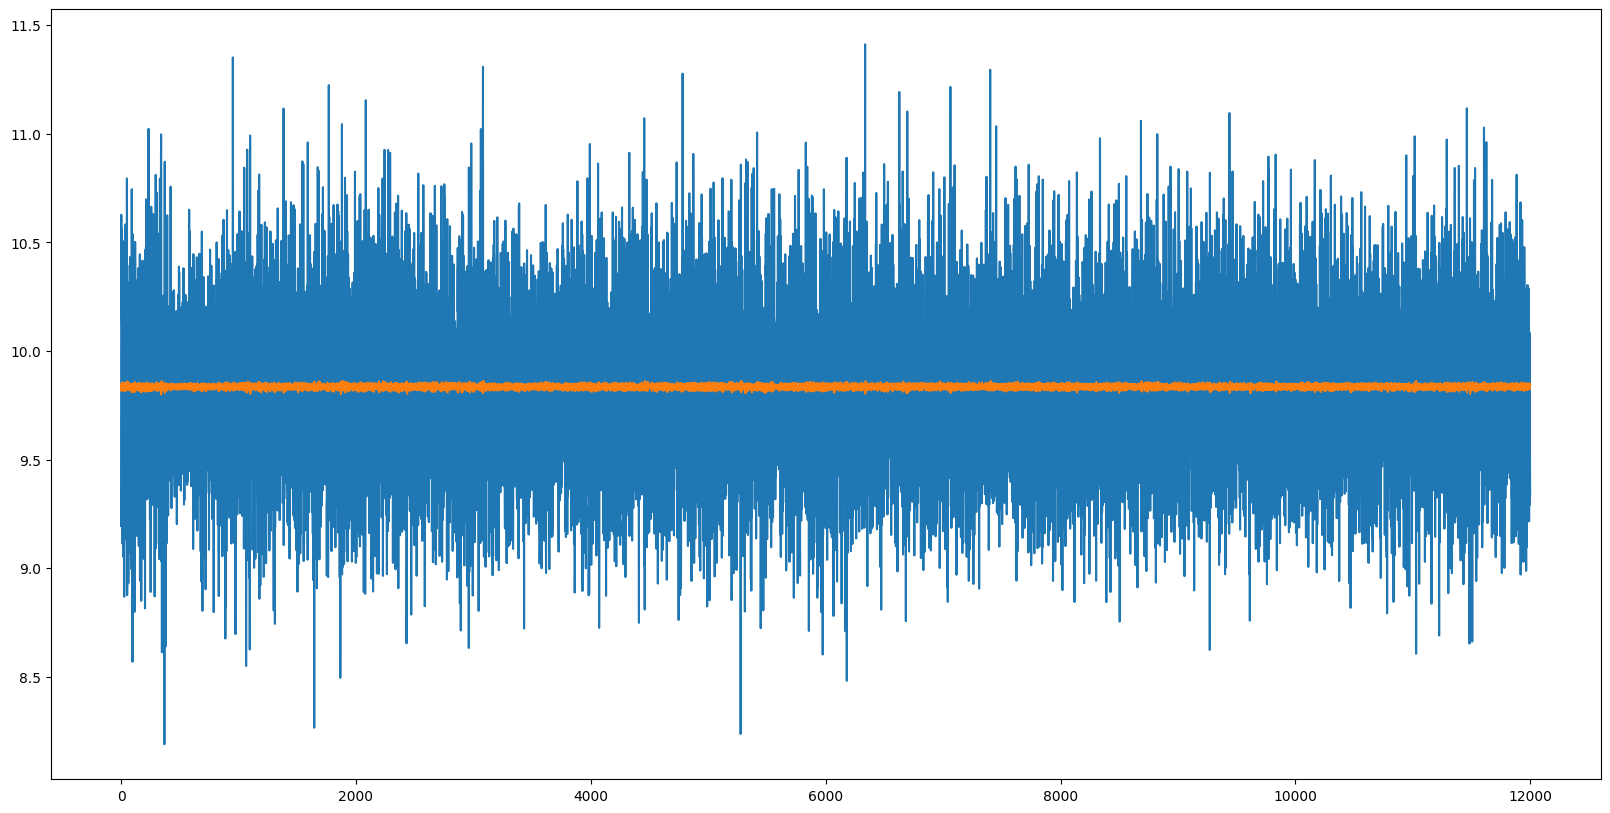

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(train_results['Actual'])
plt.plot(train_results['Train Predictions'])


In [16]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions' :val_predictions, 'Actual' :y_val})
val_results

157/157 [==============================] - 1s 2ms/step


,Val Predictions,Actual
0,9.846928,9.160687
1,9.841542,9.536050
2,9.838243,9.563928
3,9.835355,10.201605
4,9.822883,10.128941
...,...,...
4995,9.828748,10.072212
4996,9.828978,10.284606
4997,9.823614,10.285126
4998,9.819821,9.460601


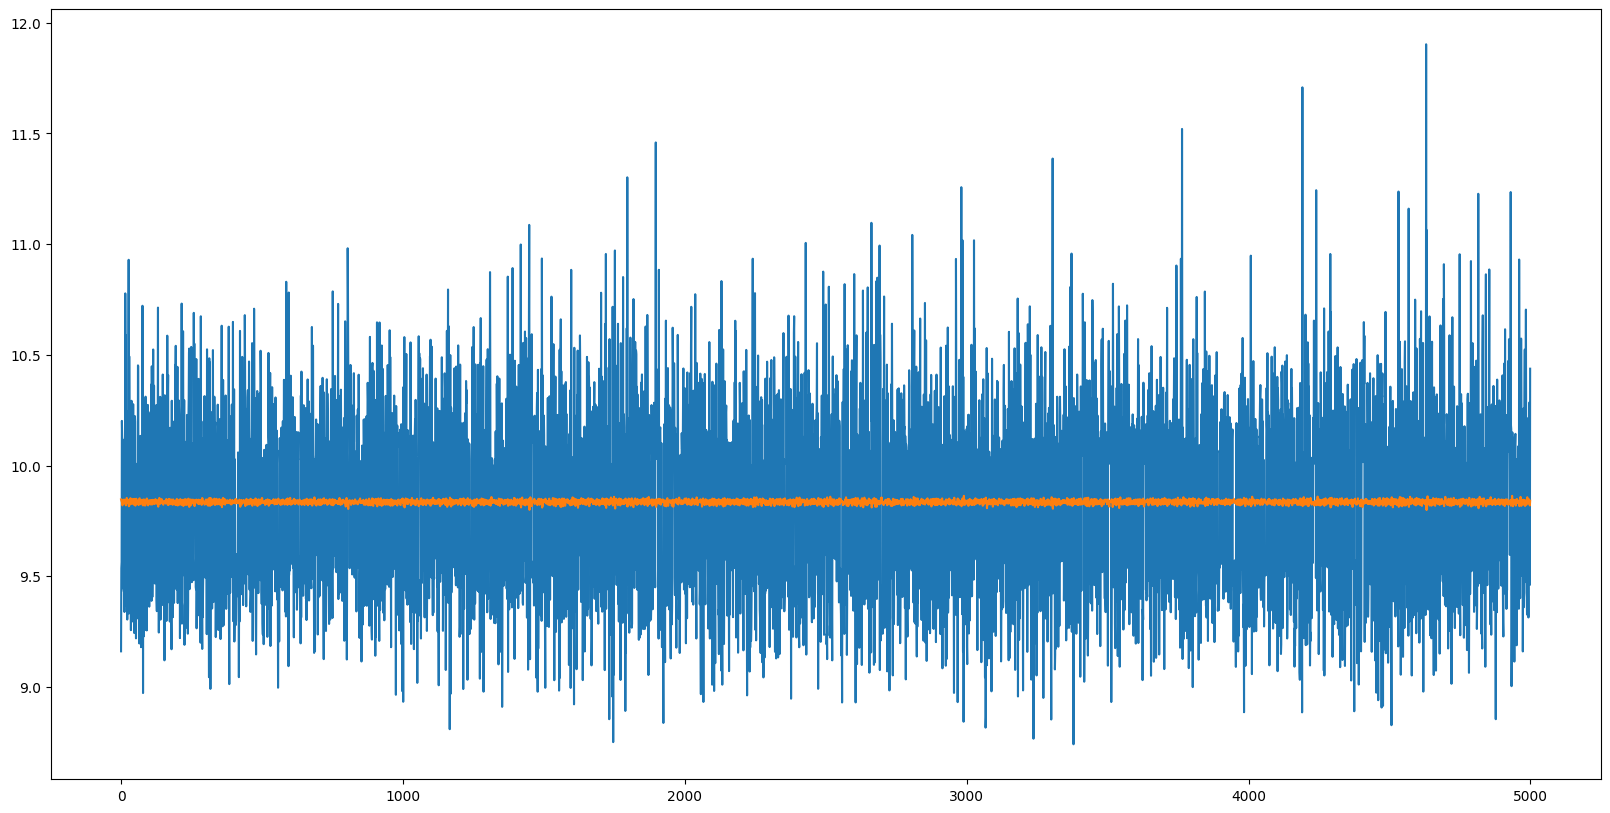

In [17]:
plt.figure(figsize=(20,10))
plt.plot(val_results['Actual'])
plt.plot(val_results['Val Predictions'])

In [18]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions' :test_predictions, 'Actual' :y_test})
test_results

52/52 [==============================] - 0s 3ms/step


,Test Predictions,Actual
0,9.831807,9.586499
1,9.845531,11.396490
2,9.816916,9.348668
3,9.831448,10.088757
4,9.836527,10.278618
...,...,...
1657,9.847086,9.490646
1658,9.834755,10.447052
1659,9.832839,9.073947
1660,9.838557,10.054511


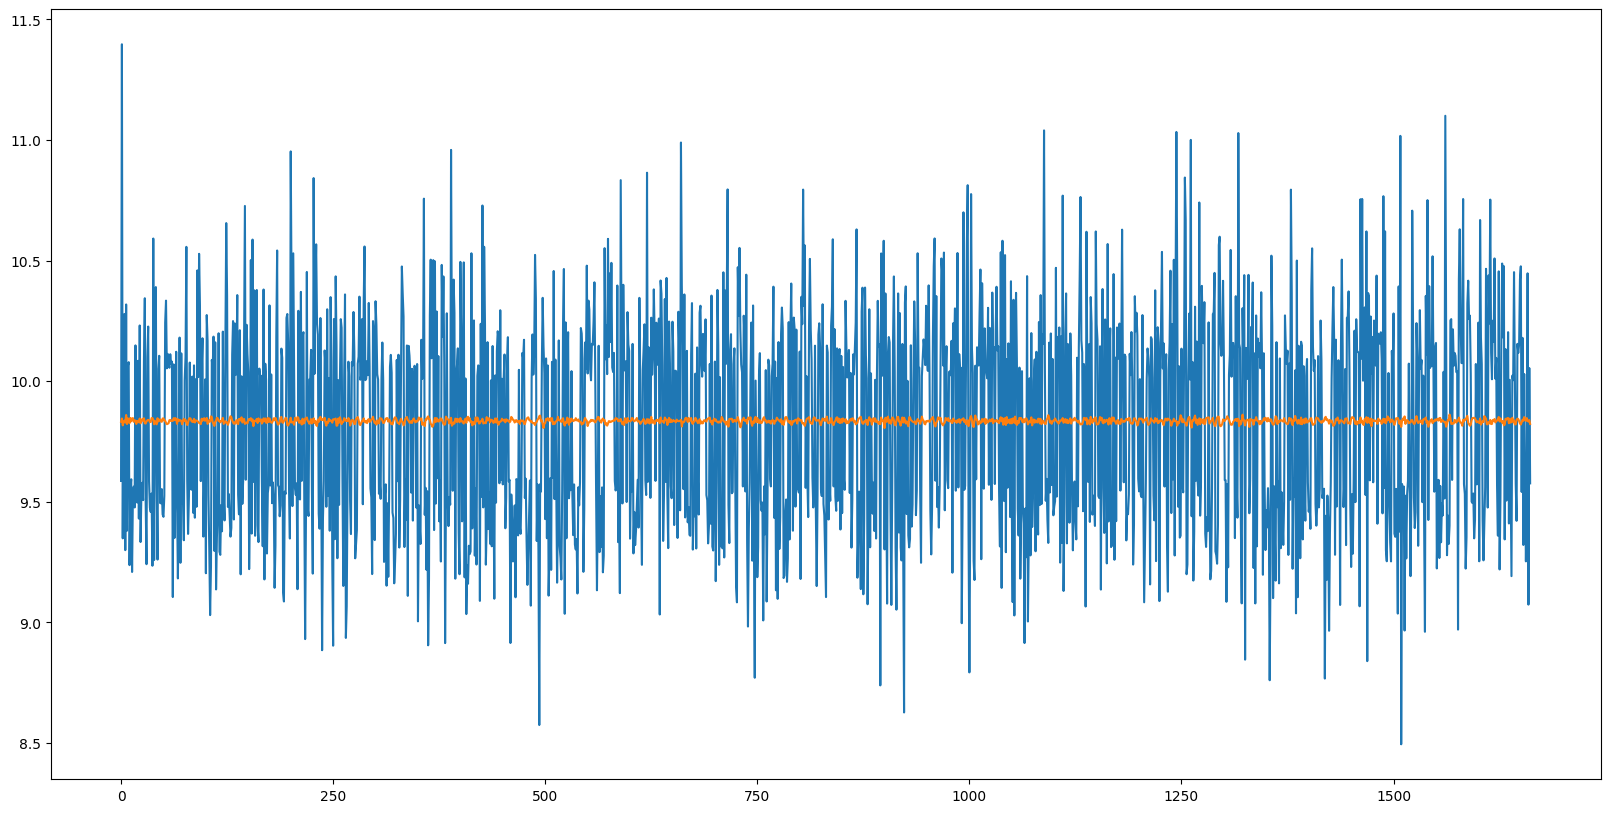

In [19]:
plt.figure(figsize=(20,10))
plt.plot(test_results['Actual'])
plt.plot(test_results['Test Predictions'])
